# 1. Requirements

In [1]:
!pip install antspyx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 8.8 MB/s eta 0:00:00


## 1.2. Import modules

In [14]:
import ants
from ants import atropos, get_ants_data, image_read, resample_image, get_mask, plot
import zipfile
import numpy as np
import nibabel as nib
import os,glob,cv2,re,json,numbers
import pylab as plt
import pandas as pd
from pathlib import *
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tf.keras.layers import ReLU
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Dense, Flatten, Input

ModuleNotFoundError: No module named 'tf'

# 2. Preprocessing

# 2.1. File Extraction

In [3]:
with zipfile.ZipFile("/content/drive/MyDrive/Parkinsons.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive")

In [4]:
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan
def normalize(image_arr):
    mean = np.mean(image_arr)
    std = np.std(image_arr)
    normalized_arr = (image_arr - mean) / std
    return normalized_arr
def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    img = ndimage.rotate(img, 90, reshape=False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img
def apply_n4_bias_field_correction(img):
    img = ants.from_numpy(img)
    mask = ants.get_mask(img)

    # Perform N4 bias field correction
    img = ants.n4_bias_field_correction(img, mask=mask, rescale_intensities=True,
                                              shrink_factor=2, convergence={'iters': [50, 50, 30, 20], 'tol': 1e-07},
                                              spline_param=None, return_bias_field=False, verbose=False, weight_mask=None)



    # Perform additional processing, for example, using atropos
    # img_corrected = atropos(a=img, x=mask, i='Kmeans[3]', m='[0.2,1x1x1]', c='[5,0]')

    # Convert to NumPy array
    img = img.numpy()

    return img

def process_scan(path):
    volume = read_nifti_file(path)
    normalized_volume = normalize(volume)
    resized_volume = resize_volume(normalized_volume)
    bias_corrected_volume = apply_n4_bias_field_correction(resized_volume)
    return bias_corrected_volume

## 2.2. Processing

In [5]:
glob_path_control = glob.glob(r"/content/drive/MyDrive/Parkinsons/sub-control*.nii.gz")
glob_path_patient = glob.glob(r"/content/drive/MyDrive/Parkinsons/sub-patient*.nii.gz")

control_data = np.array([process_scan(path) for path in glob_path_control])
patient_data = np.array([process_scan(path) for path in glob_path_patient])


control_labels = np.array([1 for _ in range(len(control_data))])
patient_labels = np.array([0 for _ in range(len(patient_data))])


X = np.concatenate((control_data, patient_data), axis=0)
print("Dataset Shape : ", X.shape)
Y = np.concatenate((control_labels, patient_labels), axis=0)
print("Label Shape : ", Y.shape)

Dataset Shape :  (83, 128, 128, 64)
Label Shape :  (83,)


## 2.3. Train-Test Dataset

In [6]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Y = to_categorical(Y, num_classes=2)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

print("X_train : ", x_train.shape)
print("X_test : ", x_test.shape)
print("Y_train : ", y_train.shape)
print("Y_test : ", y_test.shape)

X_train :  (66, 128, 128, 64)
X_test :  (17, 128, 128, 64)
Y_train :  (66, 2)
Y_test :  (17, 2)


# 3. Augmentation

In [7]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


## 3.2. Dataloader

In [8]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 2

# this will be ultimately be fed into the model
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

## 3.3. Visualizing Augmented Data

Dimension of the MRI scan is: (128, 128, 64, 1)


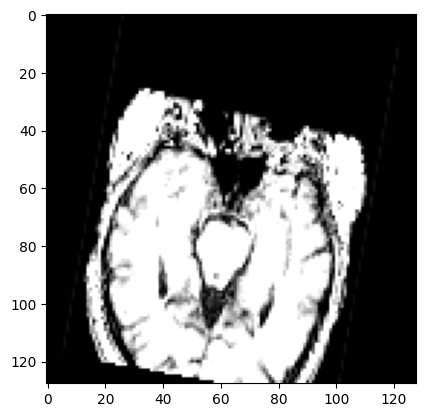

In [9]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

# 4. Models

## 4.1. Resnet 18

### 4.1.1. Architecture

In [12]:
from tensorflow.keras import layers, models
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv3D(filters1, (1, 1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, (1, 1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2, 2)):
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv3D(filters1, (1, 1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, (1, 1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = layers.Conv3D(filters3, (1, 1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_resnet18_3d(input_shape=(32, 32, 32, 1), num_classes=2):
    input_tensor = tf.keras.Input(shape=input_shape)

    x = layers.ZeroPadding3D(padding=(3, 3, 3))(input_tensor)
    x = layers.Conv3D(64, (7, 7, 7), strides=(2, 2, 2), name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding3D(padding=(1, 1, 1))(x)
    x = layers.MaxPooling3D((3, 3, 3), strides=(2, 2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = layers.GlobalAveragePooling3D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc')(x)

    model = models.Model(input_tensor, x, name='resnet18_3d')
    return model
model = build_resnet18_3d(input_shape=(128, 128, 64, 1), num_classes=2)
model.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x7c3538f26110>>

### 4.1.2. Model Compile

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50)

# Train the model, doing validation at the end of each epoch
epochs = 250
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

### 4.1.3. Result Visualization

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Calculate average accuracy

train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
print(max(val_accuracy))
average_train_accuracy = sum(train_accuracy) / len(train_accuracy)
average_val_accuracy = sum(val_accuracy) / len(val_accuracy)

print("Resnet 34")
print(f'Average Training Accuracy: {average_train_accuracy}')
print(f'Average Validation Accuracy: {average_val_accuracy}')

## 4.2. ResNet 34

### 4.2.1 Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv3D(filters1, (1, 1, 1), name=f'{conv_name_base}2a')(input_tensor)
    x = layers.BatchNormalization(name=f'{bn_name_base}2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, kernel_size, padding='same', name=f'{conv_name_base}2b')(x)
    x = layers.BatchNormalization(name=f'{bn_name_base}2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, (1, 1, 1), name=f'{conv_name_base}2c')(x)
    x = layers.BatchNormalization(name=f'{bn_name_base}2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2, 2)):
    filters1, filters2, filters3 = filters

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv3D(filters1, (1, 1, 1), strides=strides, name=f'{conv_name_base}2a')(input_tensor)
    x = layers.BatchNormalization(name=f'{bn_name_base}2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, kernel_size, padding='same', name=f'{conv_name_base}2b')(x)
    x = layers.BatchNormalization(name=f'{bn_name_base}2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, (1, 1, 1), name=f'{conv_name_base}2c')(x)
    x = layers.BatchNormalization(name=f'{bn_name_base}2c')(x)

    shortcut = layers.Conv3D(filters3, (1, 1, 1), strides=strides, name=f'{conv_name_base}1')(input_tensor)
    shortcut = layers.BatchNormalization(name=f'{bn_name_base}1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_resnet34_3d(input_shape=(32, 32, 32, 1), num_classes=2):
    input_tensor = tf.keras.Input(shape=input_shape)

    x = layers.ZeroPadding3D(padding=(3, 3, 3))(input_tensor)
    x = layers.Conv3D(64, (7, 7, 7), strides=(2, 2, 2), name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding3D(padding=(1, 1, 1))(x)
    x = layers.MaxPooling3D((3, 3, 3), strides=(2, 2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='d')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = layers.GlobalAveragePooling3D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc')(x)

    model = models.Model(input_tensor, x, name='resnet34_3d')
    return model
model2 = build_resnet34_3d(input_shape=(128, 128, 64, 1), num_classes=2)
model2.summary()

### 4.2.2. Model Compile

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50)

# Train the model, doing validation at the end of each epoch
epochs = 150
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

### 4.2.3. Result

In [ ]:
# Calculate average accuracy

train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
print(max(val_accuracy))
average_train_accuracy = sum(train_accuracy) / len(train_accuracy)
average_val_accuracy = sum(val_accuracy) / len(val_accuracy)

print("Resnet 34")
print(f'Average Training Accuracy: {average_train_accuracy}')
print(f'Average Validation Accuracy: {average_val_accuracy}')

In [ ]:

import matplotlib.pyplot as plt
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## ResNet with self attention

In [ ]:
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, ReLU, Dense, GlobalAveragePooling3D, Add
def residual_block(x, filters, kernel_size=3, strides=1, use_attention=True):
    # Convolutional layers
    residual = x
    x = Conv3D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    if use_attention:
        x = attention_block(x)

    x = Conv3D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if strides > 1:
        residual = Conv3D(filters, kernel_size=1, strides=strides, padding='same')(residual)

    # Residual connection
    x = Add()([residual, x])
    x = ReLU()(x)
    return x

def attention_block(x):
    channels = x.shape[-1]
    attention = Dense(channels, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
    x = tf.multiply(x, attention)
    return x

def build_3d_resnet(input_shape, num_classes, use_attention=True):
    input_tensor = Input(shape=input_shape)

    # Initial Convolutional Layer
    x = Conv3D(64, kernel_size=7, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual blocks
    for _ in range(3):
        x = residual_block(x, filters=64, use_attention=use_attention)

    x = residual_block(x, filters=128, strides=2, use_attention=use_attention)
    for _ in range(3):
        x = residual_block(x, filters=128, use_attention=use_attention)

    x = residual_block(x, filters=256, strides=2, use_attention=use_attention)
    for _ in range(3):
        x = residual_block(x, filters=256, use_attention=use_attention)

    x = GlobalAveragePooling3D()(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    return model


input_shape = (128, 128, 64, 1)
num_classes = 2
model = build_3d_resnet(input_shape, num_classes, use_attention=True)

model.summary()


In [18]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# Train the model, doing validation at the end of each epoch
epochs = 100
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
     epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



33/33 - 70s - loss: 612.3812 - acc: 0.4697 - val_loss: 560.8685 - val_acc: 0.3529 - 70s/epoch - 2s/step
Epoch 2/100
33/33 - 32s - loss: 521.1310 - acc: 0.6364 - val_loss: 483.4979 - val_acc: 0.3529 - 32s/epoch - 972ms/step
Epoch 3/100
33/33 - 32s - loss: 453.9549 - acc: 0.5152 - val_loss: 425.0735 - val_acc: 0.3529 - 32s/epoch - 958ms/step
Epoch 4/100
33/33 - 31s - loss: 401.5390 - acc: 0.6212 - val_loss: 378.3503 - val_acc: 0.3529 - 31s/epoch - 948ms/step
Epoch 5/100
33/33 - 32s - loss: 359.2233 - acc: 0.6212 - val_loss: 340.3438 - val_acc: 0.3529 - 32s/epoch - 966ms/step
Epoch 6/100
33/33 - 32s - loss: 324.5936 - acc: 0.6212 - val_loss: 308.9625 - val_acc: 0.3529 - 32s/epoch - 981ms/step
Epoch 7/100
33/33 - 31s - loss: 295.4652 - acc: 0.5758 - val_loss: 282.0195 - val_acc: 0.3529 - 31s/epoch - 953ms/step
Epoch 8/100
33/33 - 32s - loss: 270.2585 - acc: 0.5303 - val_loss: 258.5164 - val_acc: 0.3529 - 32s/epoch - 970ms/step
Epoch 9/100
33/33 - 32s - loss: 248.0933 - acc: 0.6212 - val_lo

In [19]:
# Calculate average accuracy

train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
print(max(val_accuracy))
average_train_accuracy = sum(train_accuracy) / len(train_accuracy)
average_val_accuracy = sum(val_accuracy) / len(val_accuracy)

print("Resnet 34 with attention")
print(f'Average Training Accuracy: {average_train_accuracy}')
print(f'Average Validation Accuracy: {average_val_accuracy}')


0.7058823704719543
Resnet 34 with attention
Average Training Accuracy: 0.5990909069776535
Average Validation Accuracy: 0.5029411917924881


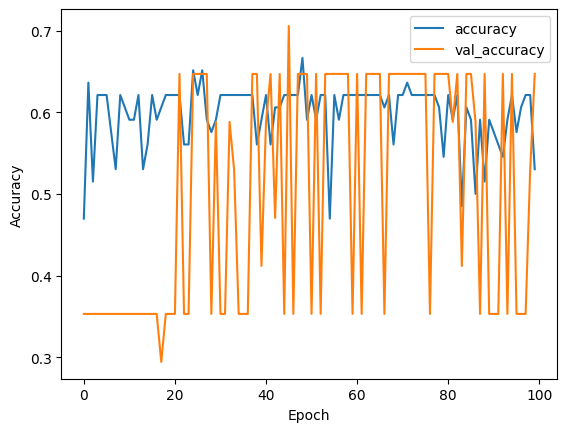

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()